In [1]:
from read_data import AnalyzePOWHEGData
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
from scipy.optimize import curve_fit, minimize

luminosity_factor = 2
init_rebinning = 4
min_num_events = 20
data =AnalyzePOWHEGData()

Enu,pred,pred_min,pred_max = data.rebin_data(luminosity_factor=luminosity_factor,init_rebinning=init_rebinning,min_num_events=min_num_events)

print('Enu =')
print(Enu)
Enu = torch.tensor(Enu, dtype=torch.float32).view(-1, 1)
pred = np.array(pred)
print(f'pred = {pred}')

[  25.         74.791667  124.58333   174.375     224.16667   273.95833
  323.75      373.54167   423.33333   473.125     522.91667   572.70833
  622.5       672.29167   722.08333   771.875     821.66667   871.45833
  921.25      971.04167  1020.8333   1070.625    1120.4167   1170.2083
 1220.       1269.7917   1319.5833   1369.375    1419.1667   1468.9583
 1518.75     1568.5417   1618.3333   1668.125    1717.9167   1767.7083
 1817.5      1867.2917   1917.0833   1966.875    2016.6667   2066.4583
 2116.25     2166.0417   2215.8333   2265.625    2315.4167   2365.2083
 2415.       2464.7917   2514.5833   2564.375    2614.1667   2663.9583
 2713.75     2763.5417   2813.3333   2863.125    2912.9167   2962.7083
 3012.5      3062.2917   3112.0833   3161.875    3211.6667   3261.4583
 3311.25     3361.0417   3410.8333   3460.625    3510.4167   3560.2083
 3610.       3659.7917   3709.5833   3759.375    3809.1667   3858.9583
 3908.75     3958.5417   4008.3333   4058.125    4107.9167   4157.7083
 42

In [2]:
# compute systematic error on data
delta_plus = pred_max - pred
delta_min = pred_min- pred
semi_diff = (delta_plus + delta_min) / 2
average = (delta_plus - delta_min) / 2
se_delta = semi_diff
sig_sys = np.sqrt(average * average + 2 * semi_diff * semi_diff)

# compute covariance matrix of data
sig_tot = sig_sys**2 + pred
cov_matrix = sig_tot 
cov_matrix = np.diag(sig_tot)
cov_matrix = np.linalg.inv(cov_matrix)


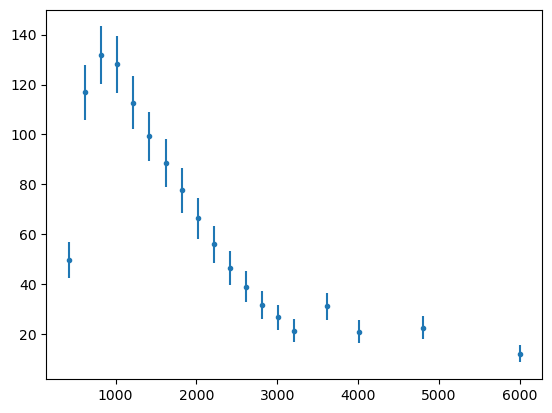

In [3]:
plt.errorbar(Enu,pred,yerr = np.sqrt(sig_tot),fmt = '.')
plt.show()

/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_64968/3848171228.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_nu = torch.tensor(x_nu, dtype=torch.float32).view(-1, 1)


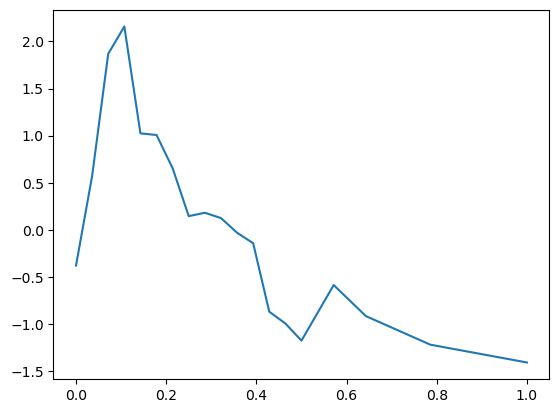

In [4]:
# generate MC replicas using level 2 closure fit

r_sys = np.random.normal(0,sig_sys)
r_stat = np.random.normal(0,np.sqrt(pred))

x_nu = (Enu - Enu.min()) / (Enu.max() - Enu.min())
# x_nu = Enu/14000
# x_nu = np.log(Enu)
x_nu = torch.tensor(x_nu, dtype=torch.float32).view(-1, 1)

replicas  = 1
MC_data,MC_data_means,MC_data_stds = [],[],[]
pred_level1 = pred + r_sys + r_stat

for _ in range(replicas):
    r_sys = np.random.normal(0,sig_sys)
    r_stat = np.random.normal(0,np.sqrt(pred))

    pred_level2 = pred_level1 + r_sys + r_stat

    pred_level2_mean, pred_level2_std = pred_level2.mean(), pred_level2.std()
    pred_level2 = (pred_level2 - pred_level2_mean) / pred_level2_std    
    pred_level2 = torch.tensor(pred_level2, dtype=torch.float32).view(-1, 1)
    
    MC_data.append(pred_level2)
    MC_data_means.append(pred_level2_mean)
    MC_data_stds.append(pred_level2_std)

plt.plot(x_nu,pred_level2)
plt.show()

In [5]:
#specify MLP
class SimplePerceptron(torch.nn.Module):
    def __init__(self, l1,l2):
        super(SimplePerceptron, self).__init__()
        self.linear = torch.nn.Linear(1,l1)
        self.hidden = torch.nn.Linear(l1,l2)
        self.hidden2 = torch.nn.Linear(l2,1)
        # self.hidden3 = torch.nn.Linear(l3,1)
        self.relu = torch.nn.ReLU()

    def forward(self, y):
        y = self.linear(y)
        y = self.relu(y)
        y = self.hidden(y)
        y = self.relu(y)
        y = self.hidden2(y)
        # y = self.relu(y)
        # y = self.hidden3(y)

        return y

In [6]:
import torch.nn as nn
class CustomPreprocessing(nn.Module):
    def __init__(self, alpha,beta,gamma):
        super(CustomPreprocessing, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
        self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32, requires_grad=True))
        self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32, requires_grad=True))

    def forward(self, x):
        # Ensure x values are within valid range (0 < x < 1)
        x = torch.clamp(x, 1e-6, 1 - 1e-6)  # Avoid division by zero or log errors
        return self.gamma*(1 - x) ** self.beta * x ** (1 - self.alpha)

In [7]:
# Combine the preprocessing and MLP in a single model
class PreprocessedMLP(nn.Module):
    def __init__(self, alpha, beta, gamma,l1, l2):
        super(PreprocessedMLP, self).__init__()
        self.preprocessing = CustomPreprocessing(alpha, beta,gamma)
        self.mlp = SimplePerceptron(l1, l2)

    def forward(self, x):
        x = self.preprocessing(x)
        x = self.mlp(x)
        return x

In [8]:
i=0
pred_stoch = MC_data[i].clone()  # Keeps the original intact
MC_data[i] = MC_data[i].flatten().numpy()
MC_data[i] = MC_data[i]* MC_data_stds[i] + MC_data_means[i]

In [9]:
def nn_fit(parr):
    fits = []

    alpha = 0.5  # Example alpha value
    beta = 2.0   # Example beta value
    gamma = 10
    
    l1 = int(parr[0])
    l2 = int(parr[1])
    lr = (parr[2])
    nepochs = int(parr[3])

    criterion = torch.nn.MSELoss()
    model = PreprocessedMLP(alpha, beta, gamma,l1, l2)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()

    for _ in range(nepochs):
        # It is important to shuffle the dataset at each epoch so that the batches are not always the same
        optimizer.zero_grad()

        y_pred = model(x_nu)  # Use all data directly
        loss = criterion(y_pred, pred_stoch)

        loss.backward()
        optimizer.step()

    y_pred = model(x_nu)
    y_pred = y_pred.detach().numpy()
    y_pred = y_pred.flatten()

    y_pred = y_pred * MC_data_stds[i] + MC_data_means[i]
    fits.append(y_pred)
    
    return fits

In [ ]:
def compute_chi_square(parr):
    fits = nn_fit(parr)
    mean_fit = np.mean(fits,axis=0)
    red_chi_square = 1/pred_stoch.size(0) * np.dot(mean_fit - pred_level1,np.matmul(cov_matrix, mean_fit - pred_level1))
    print(f"l1= {parr[0]},l2= {parr[1]},lr= {parr[2]},epochs= {parr[3]},")
    print(f"reduced chi^2= {red_chi_square}")
    return red_chi_square - 2


In [10]:

# x has to be in a certain range
# 3 have to be integers
# See if we can also constrain number of layers combined with number of nodes per layer
# Also look at NNPDF code to see what they are doing
x0 = [8,20,0.001,900]
result = minimize(compute_chi_square,x0,method = 'BFGS')
print(f' {result.x}')


l1= 8,l2= 20,lr= 0.001,epochs= 900,
reduced chi^2= 2.673538918642276
l1= 8,l2= 20,lr= 0.001,epochs= 900,
reduced chi^2= 3.125769446703128
l1= 8,l2= 20,lr= 0.001,epochs= 900,
reduced chi^2= 2.874027480237049
l1= 8,l2= 20,lr= 0.0010000149011611939,epochs= 900,
reduced chi^2= 2.160872856605589
l1= 8,l2= 20,lr= 0.001,epochs= 900,
reduced chi^2= 2.8202641854028387
l1= 7,l2= 19,lr= 0.7128726120515896,epochs= 899,
reduced chi^2= 43.22172530220394
l1= 7,l2= 19,lr= 0.7128726120515896,epochs= 899,
reduced chi^2= 43.22173492832131
l1= 7,l2= 19,lr= 0.7128726120515896,epochs= 899,
reduced chi^2= 43.22210072299324
l1= 7,l2= 19,lr= 0.7128726269527508,epochs= 899,
reduced chi^2= 43.22173492832131
l1= 7,l2= 19,lr= 0.7128726120515896,epochs= 899,
reduced chi^2= 41.00699112377544
l1= 7,l2= 19,lr= 0.3160663297349814,epochs= 899,
reduced chi^2= 43.22173492832131
l1= 7,l2= 19,lr= 0.3160663297349814,epochs= 899,
reduced chi^2= 7.057521338327845
l1= 7,l2= 19,lr= 0.3160663297349814,epochs= 899,
reduced chi^2= 

In [ ]:
Enu = Enu.detach().numpy()
Enu = Enu.flatten()


In [ ]:
print(Enu.min())

423.33334


In [ ]:
# MC_mean = torch.mean(torch.stack(MC_data, dim=0), dim=0)

MC_mean = np.mean(MC_data,axis=0)
MC_mean = np.array(MC_mean).flatten()

In [ ]:
sigma_fit = np.std(fits,axis=0)
sigma_fit = sigma_fit.flatten()

In [ ]:
mean_fit = np.mean(fits,axis=0)

In [ ]:
sigma_data = np.sqrt(sig_tot)

In [ ]:
x_fit  = x_fit.flatten()
#  y_pred = y_pred * MC_data_stds[i] + MC_data_means[i]
# x_fit = x_fit*Enu_std + Enu_mean
x_fit = x_fit *(Enu.max()-Enu.min()) + Enu.min()


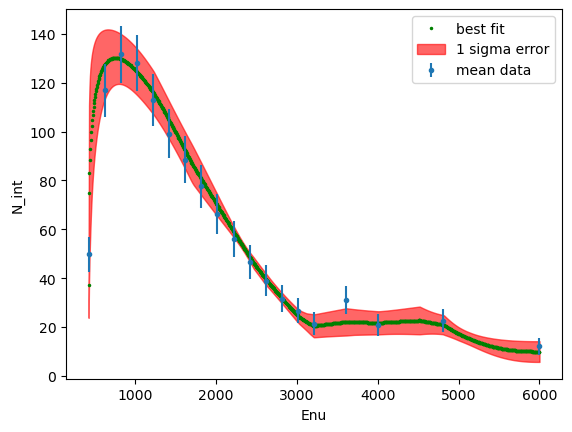

In [ ]:

plt.plot(x_fit,mean_fit,'go',label='best fit',markersize=1.5)
plt.fill_between(x_fit,mean_fit+sigma_fit,mean_fit-sigma_fit,label='1 sigma error',color = 'red',alpha=0.6)
plt.errorbar(Enu,pred,yerr = sigma_data,label = 'mean data',fmt = '.')
plt.xlabel('Enu')
plt.ylabel('N_int')
plt.legend()    

# plt.savefig('level_2_ML_fit.pdf')
plt.show()

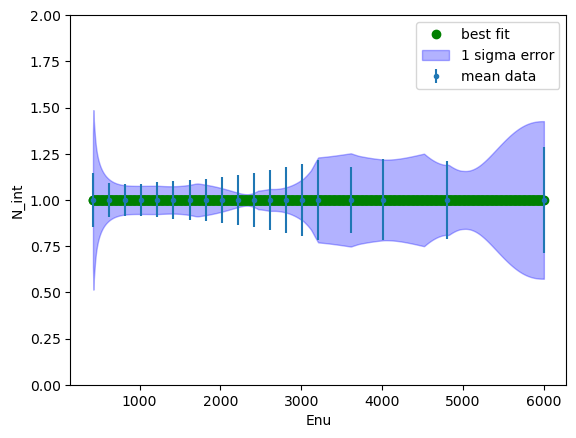

In [ ]:
# This plot is to see the relative error of the ML fit
plt.plot(x_fit,mean_fit/mean_fit,'go',label='best fit')

plt.errorbar(Enu,pred/pred,yerr = sigma_data/pred,label = 'mean data',fmt = '.')

plt.fill_between(x_fit,(mean_fit+sigma_fit)/mean_fit,(mean_fit-sigma_fit)/mean_fit,label='1 sigma error',color = 'blue',alpha=0.3)
plt.xlabel('Enu')
plt.ylabel('N_int')
plt.legend()
plt.ylim(0,2)
plt.show()